# Neighborhood enrichment test on image data

This tutorial explains how to conduct a neighborhood enrichment test (see [Wählby et al. (2022)](https://www.frontiersin.org/articles/10.3389/fphys.2022) for explanation) on image data with napari-spatial-statistics. This function uses the [Squidpy](https://squidpy.readthedocs.io/en/stable/index.html) spatial statistics platform.

In [1]:
import napari 
import napari_spatial_statistics as nss
import matplotlib.pyplot as plt
import pandas as pd

### Non-random spots

We first create some sample data and add a small amount of "randomness" to it so that the locations of multiple types of objects are close to each other, but not directly on top of each other.

In [2]:
spots = nss.make_random_spots(n_spots=1000, n_classes=2, spatial_size=500, dim=3, sigma=2.5, randomness=10)

e:\biapol\projects\napari-spatial-statistics\src\napari_spatial_statistics\_sample_data.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[[locations[:, i] for i in range(locations.shape[1])]] = 1


Assistant skips harvesting pyclesperanto as it's not installed.


C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


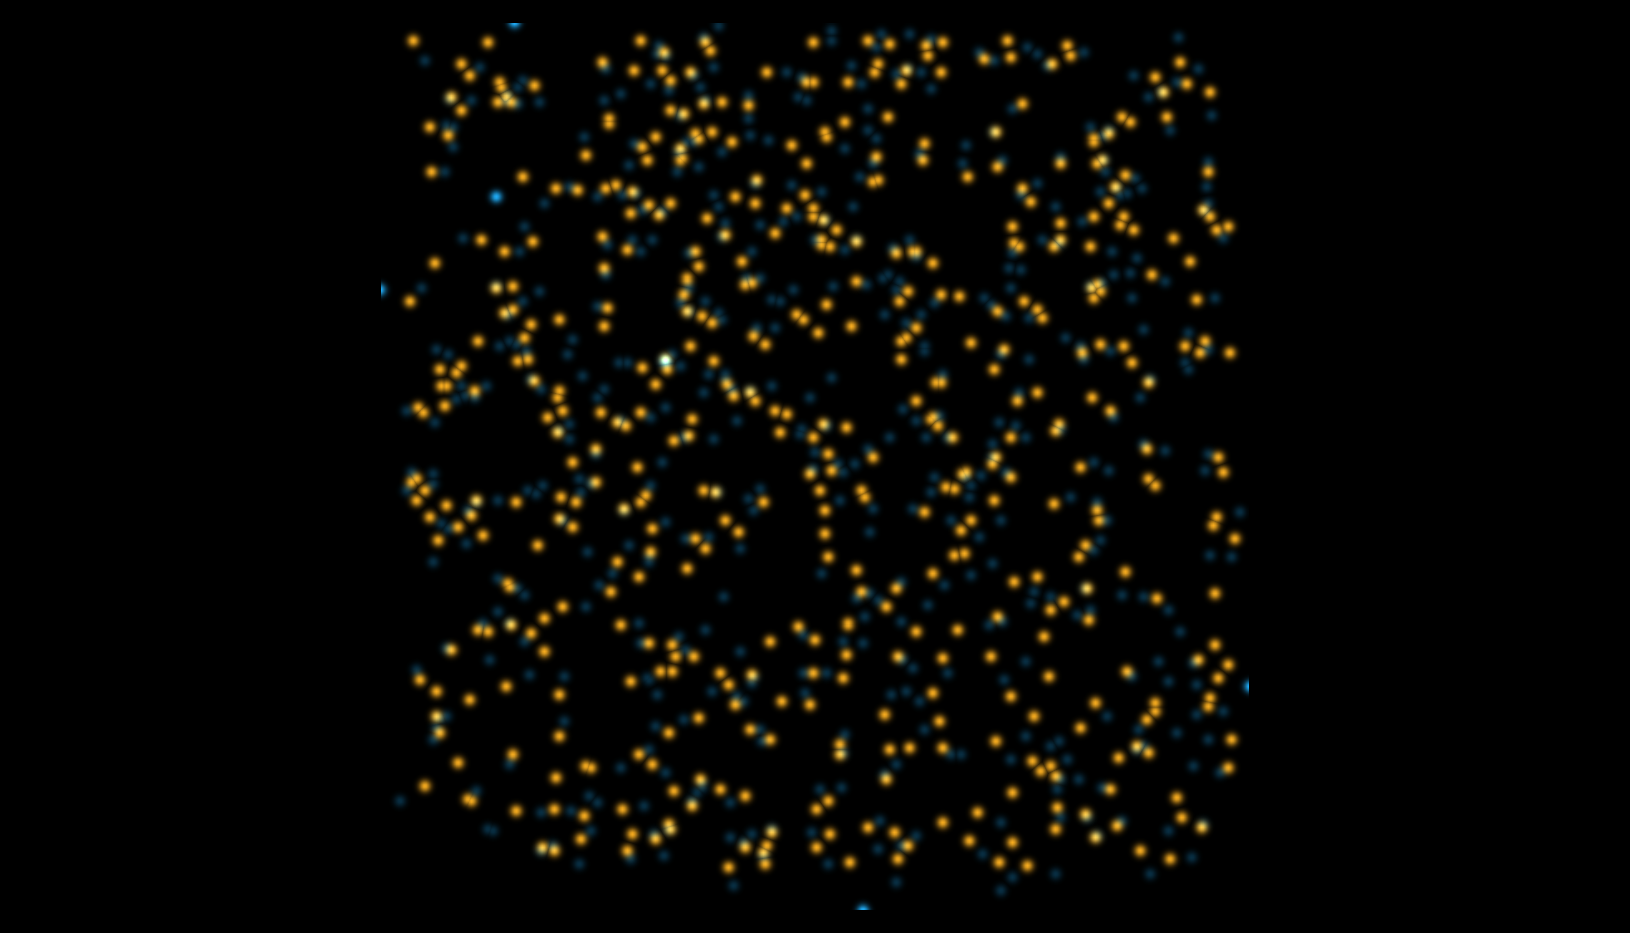

In [3]:
viewer = napari.Viewer(ndisplay=3)

for spot in spots:
    viewer.add_image(spot[0], **spot[1], blending='additive')
    
napari.utils.nbscreenshot(viewer, canvas_only=True)

Now we try to detect the location of the spots and put them into a separate points layer for each color channel:

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


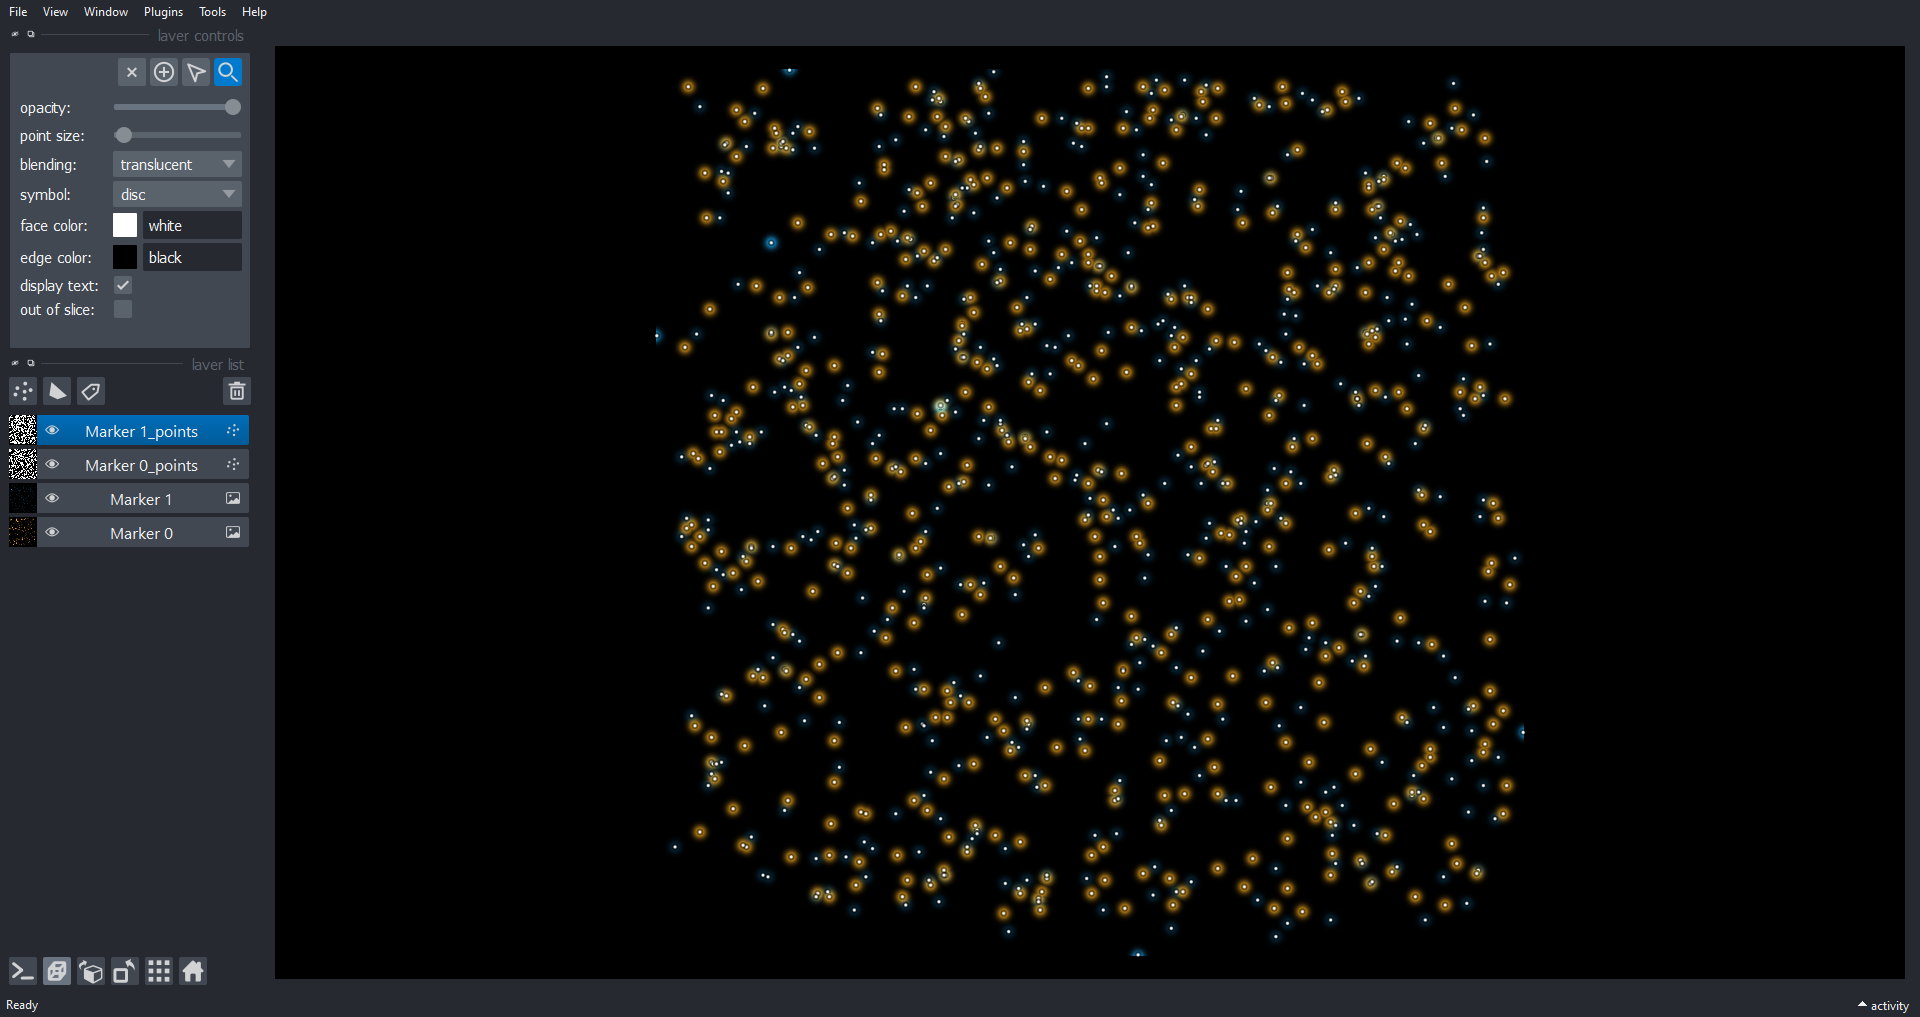

In [4]:
maxima_layers = []
for spot in spots:
    maxima = nss.detect_maxima(spot[0], threshold_value=0.25, exclude_border=False, minimal_distance=5)
    maxima_layers.append(viewer.add_points(maxima, name=spot[1]['name'] + '_points', size=3.0))
    
napari.utils.nbscreenshot(viewer)

Since the neighborhood enrichment test and the neighborhood determination operates on single points layers, we will merge the created points layers into a single layer and store the point identities into `layer.properties`:

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


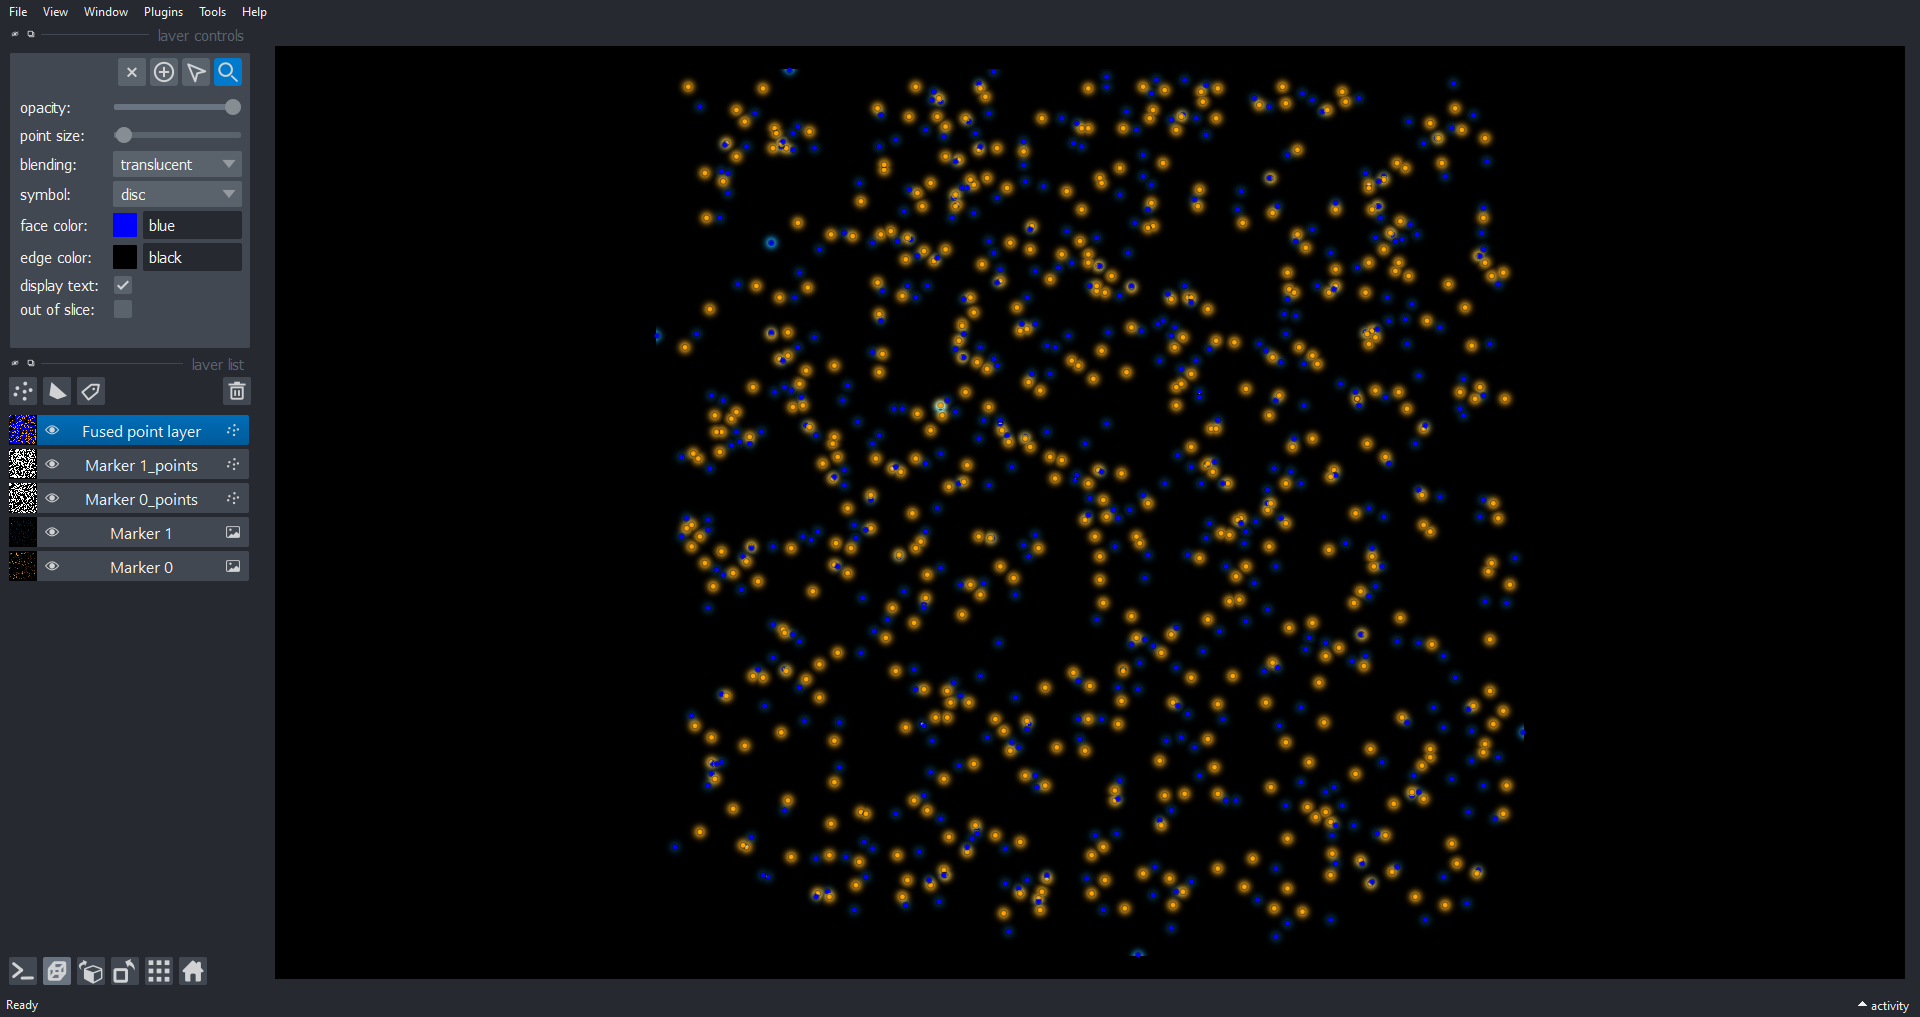

In [5]:
points_merged = nss.merge_points_layers(viewer)
viewer.add_points(points_merged[0], **points_merged[1])
napari.utils.nbscreenshot(viewer, canvas_only=False)

Similarly to [this notebook]('./Neighborhood_enrichment_test_points'), we can now determine the neighborhood between the points with a method of our choice:
    
* `nss.distance_ckdtree()`: Distance-based neighborhood implemented in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html)
* `nss.distance_squidpy()`: Distance-based neighborhood implement in [Squidpy](https://squidpy.readthedocs.io/en/stable/auto_examples/graph/compute_spatial_neighbors.html)
* `nss.knearest_ckdtree()`: N-nearest neighbors implemented in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html#scipy.spatial.cKDTree.query)

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


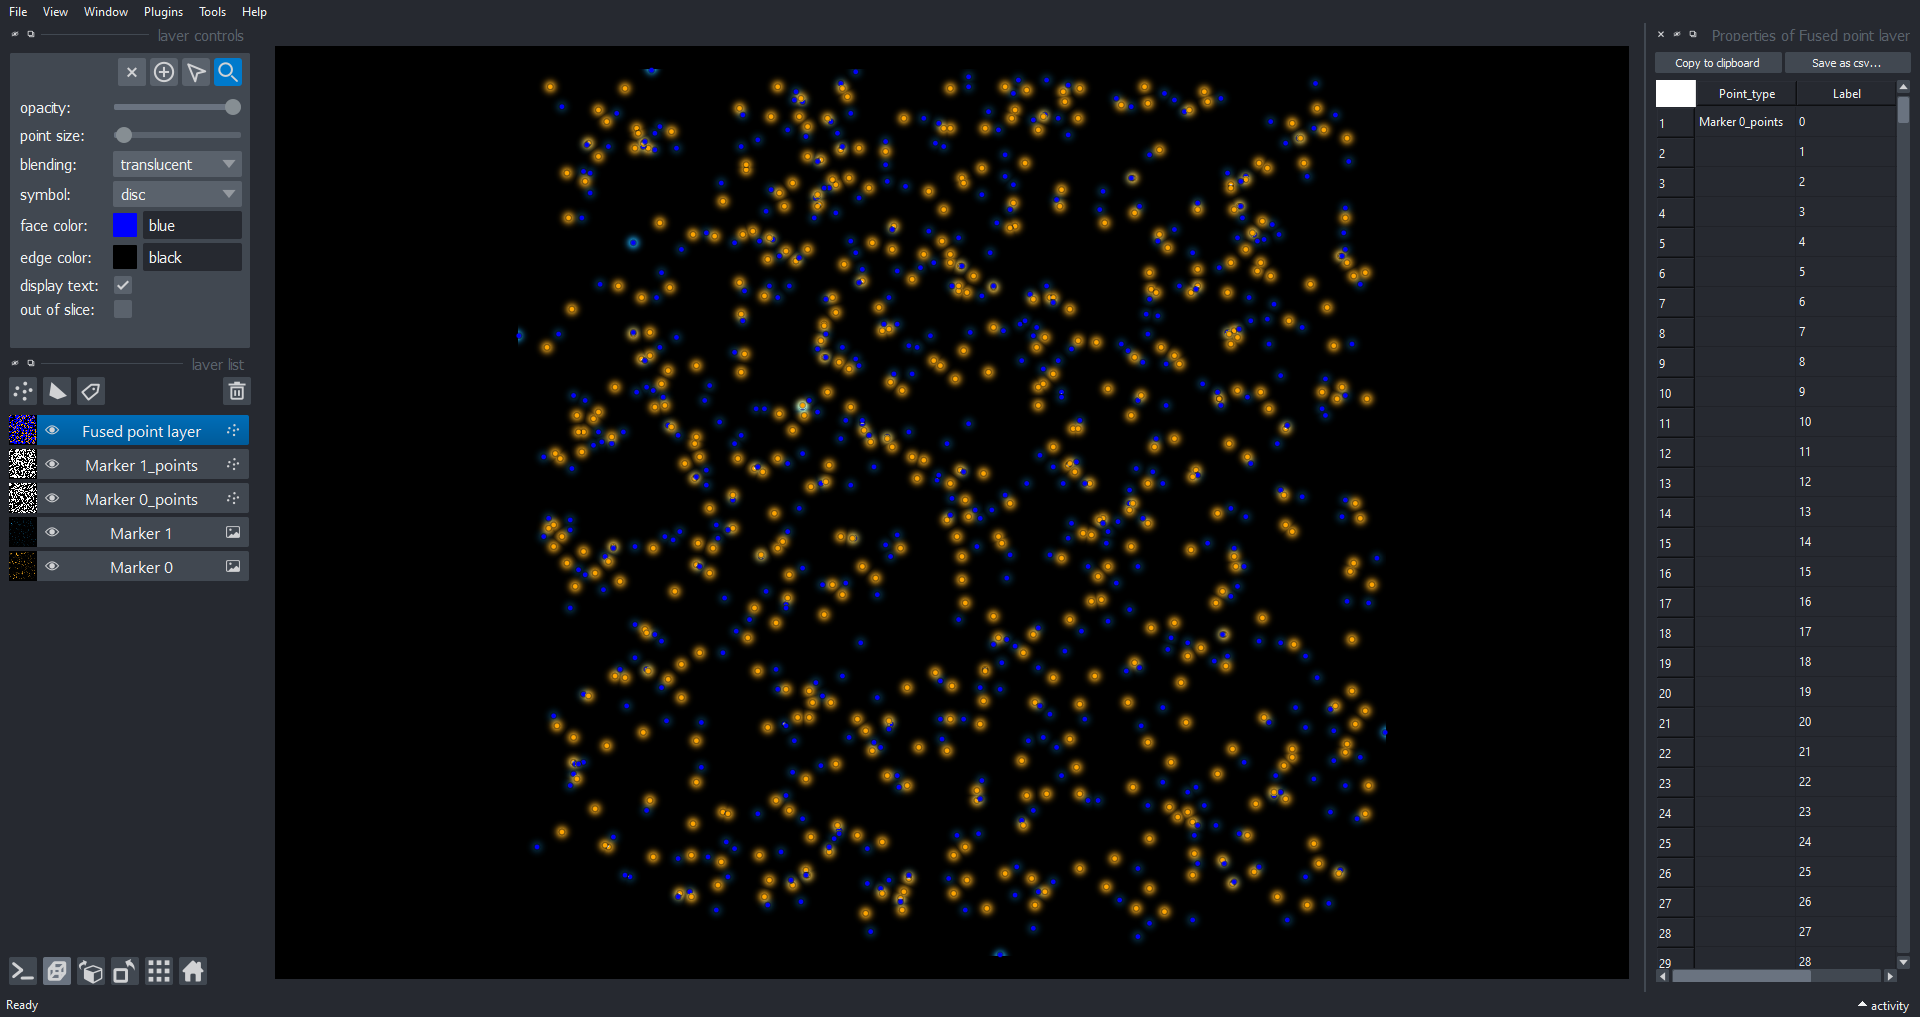

In [6]:
properties = nss.distance_ckdtree(points_merged, radius=20, viewer=viewer)
napari.utils.nbscreenshot(viewer, canvas_only=False)

*Note*: using the `merge_points_layers()` function reads the name of ach points layer and adds a column `Point_type` to the `layer.properties` of the merged layer which tells from which layer the respective point comes from. The widget on the right hand side is simply a view on `points_merged.properties`:

In [7]:
pd.DataFrame(properties)

Point_type  Label    neighbors
0    Marker 0_points      0      0,1,558
1    Marker 0_points      1      0,1,558
2    Marker 0_points      2  2,3,821,871
3    Marker 0_points      3          2,3
4    Marker 0_points      4  4,5,800,878
..               ...    ...          ...
995  Marker 1_points    995  491,994,995
996  Marker 1_points    996      484,996
997  Marker 1_points    997      446,997
998  Marker 1_points    998      439,998
999  Marker 1_points    999      411,999

[1000 rows x 3 columns]

  0%|          | 0/1000 [00:00<?, ?/s]

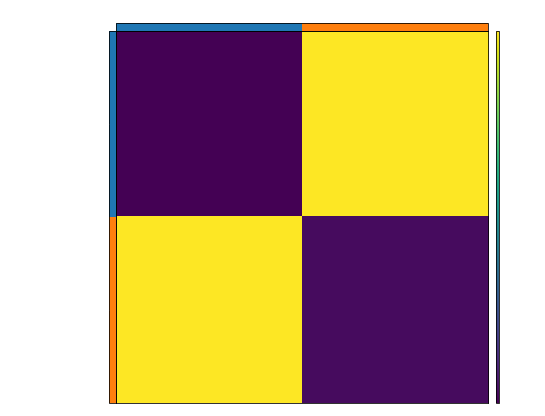

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
results = nss.neighborhood_enrichment_test(points_merged[0], properties=properties, on_feature='Point_type', n_permutations=1000, ax=ax)

Again, we can see that the spots of the two types `Marker 1_points` and `Marker 2_points` appear spatially over-enriched in each other's immediate neighborhood.

### Random spots

We can repeat the above analysis with a higher amount of "randomness" to see how this is reflected in the neighborhood enrichment analysis:

In [9]:
viewer2 = napari.Viewer(ndisplay=3)
spots = nss.make_random_spots(n_spots=1000, n_classes=2, spatial_size=500, dim=3, sigma=2.5, randomness=50)

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
e:\biapol\projects\napari-spatial-statistics\src\napari_spatial_statistics\_sample_data.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  image[[locations[:, i] for i in range(locations.shape[1])]] = 1


In [10]:
# Detect maxima
maxima_layers = []
for spot in spots:
    maxima = nss.detect_maxima(spot[0], threshold_value=0.25, exclude_border=False, minimal_distance=5)
    maxima_layers.append(viewer2.add_points(maxima, name=spot[1]['name'] + '_points', size=3.0))
    
points_merged = nss.merge_points_layers(viewer2)
viewer2.add_points(points_merged[0], **points_merged[1])

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Fused point layer' at 0x1de49918b20>

In [11]:
# Get neighborhood
properties = nss.distance_ckdtree(points_merged, radius=20, viewer=viewer2)

C:\Users\johan\anaconda3\envs\napari-spatial-statistics\lib\site-packages\numpy\core\numeric.py:2453: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


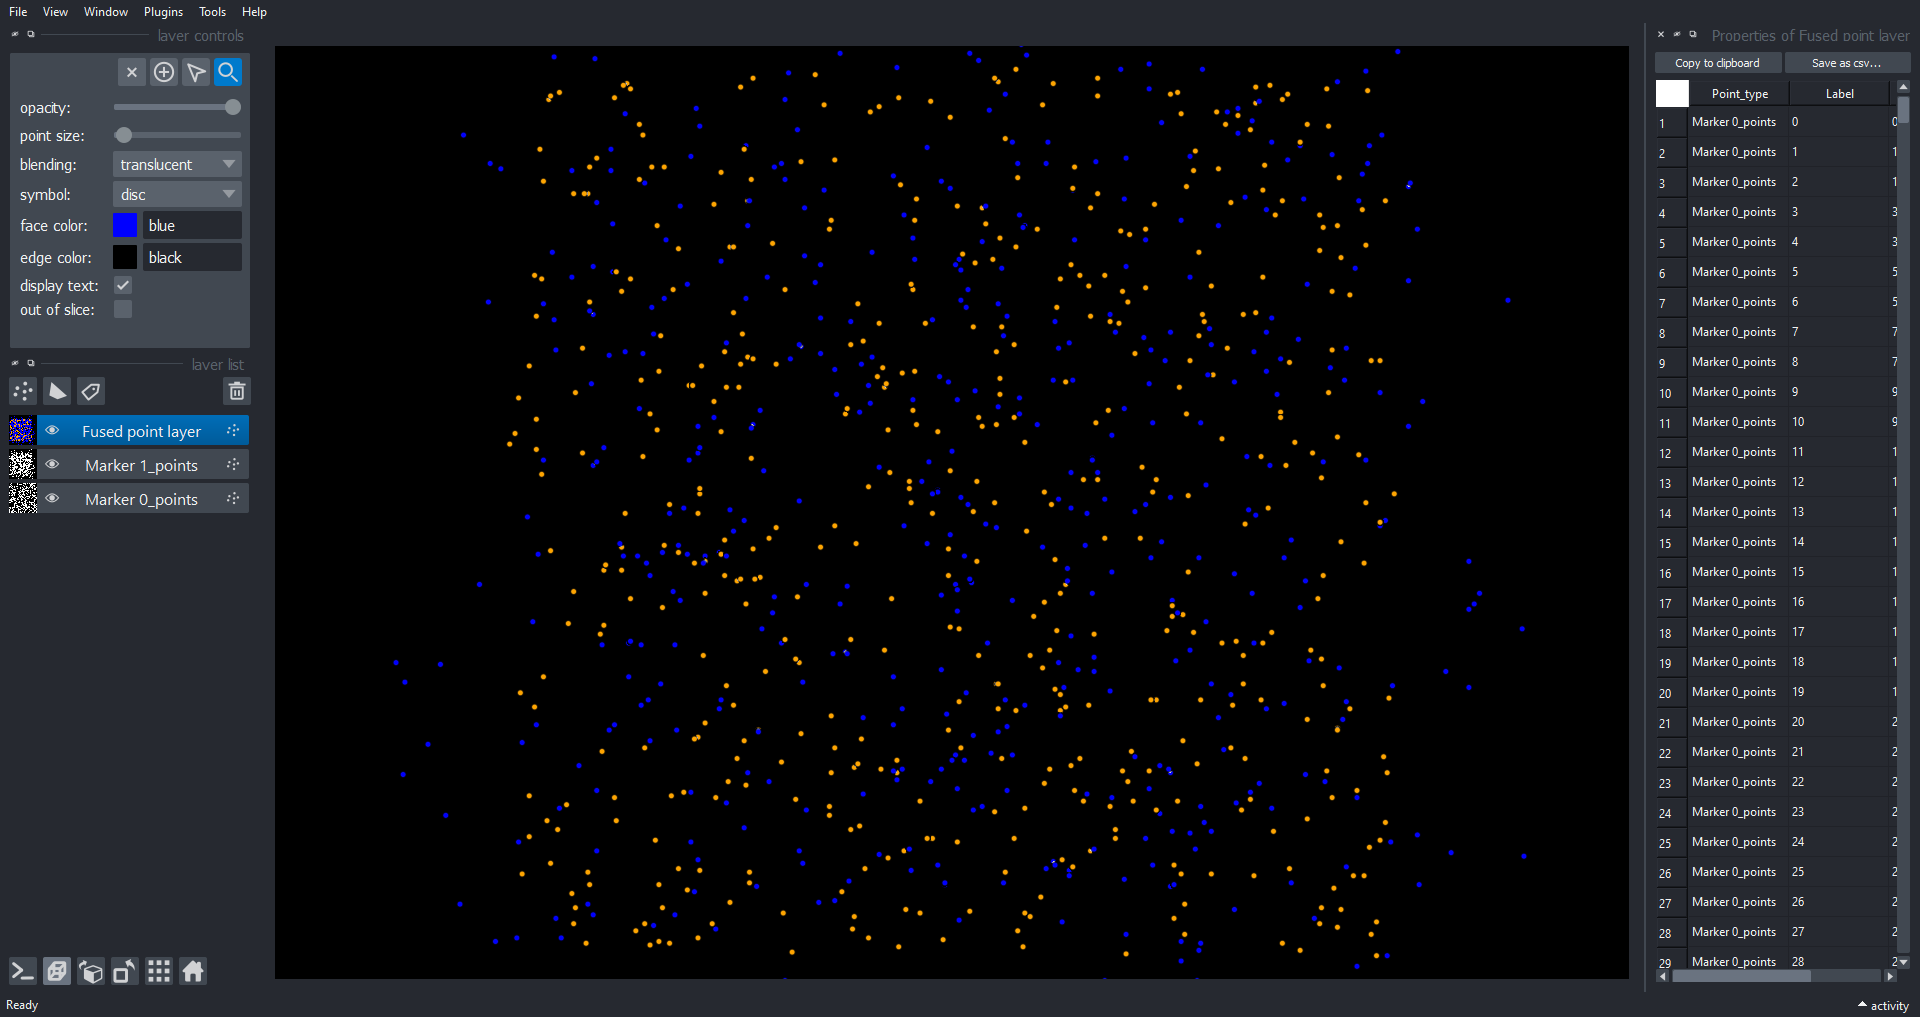

In [12]:
napari.utils.nbscreenshot(viewer2, canvas_only=False)

In [13]:
pd.DataFrame(properties)

Point_type  Label neighbors
0    Marker 0_points      0         0
1    Marker 0_points      1       1,2
2    Marker 0_points      2       1,2
3    Marker 0_points      3       3,4
4    Marker 0_points      4       3,4
..               ...    ...       ...
992  Marker 1_points    992       992
993  Marker 1_points    993   983,993
994  Marker 1_points    994       994
995  Marker 1_points    995  9,10,995
996  Marker 1_points    996       996

[997 rows x 3 columns]

  0%|          | 0/1000 [00:00<?, ?/s]

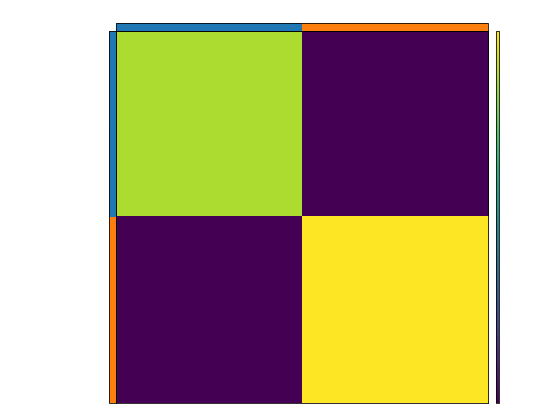

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
results = nss.neighborhood_enrichment_test(points_merged[0], properties=properties, on_feature='Point_type', n_permutations=1000, ax=ax)

You can appreciate that the neighborhood enrichment scores are considerably closer to zero (no over-enrichment/over-depletion) for the data with more randomness than for the example above.

In [15]:
results

{'zscore': array([[ 0.07130524, -0.15129011],
        [-0.15129011,  0.10215583]]),
 'count': array([[555,  54],
        [ 54, 554]], dtype=uint32)}